# SGD Classifier with Regularizaion

## Regularisation 
There are two elementary regularisers, the L1 and L2 regularisation, also known as Lasso and Ridge penalty, respectively.

In [3]:
import numpy as np
import struct 
import gzip
import pandas as pd 
import sklearn
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition
import sklearn.pipeline# adjust settings to plot nice figures inline
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [4]:
# data directory
data_dir = 'mnist'
import torchvision.datasets as dset

# train data
train_set = dset.MNIST(root=data_dir, train=True, download=True)
train_x_mnist = np.array(train_set.train_data)
train_y_mnist = np.array(train_set.train_labels)

# test data
test_set = dset.MNIST(root=data_dir, train=False, download=True)
test_x_mnist = np.array(test_set.test_data)
test_y_mnist = np.array(test_set.test_labels)

0it [00:00, ?it/s]

 99%|█████████▉| 9854976/9912422 [00:13<00:00, 1684507.46it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz



0it [00:00, ?it/s]


 57%|█████▋    | 16384/28881 [00:00<00:00, 123836.06it/s]
32768it [00:00, 93865.79it/s]                            
0it [00:00, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz



 99%|█████████▉| 1638400/1648877 [00:03<00:00, 613154.66it/s]
1654784it [00:03, 476899.08it/s]                             
0it [00:00, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz



  0%|          | 0/4542 [00:00<?, ?it/s]
8192it [00:00, 39665.33it/s]            

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


9920512it [00:30, 1684507.46it/s]                             

In [5]:
############################################################################
# Extract sample digits 
############################################################################

def sample_data_digits(data, labels, labels_to_select):
    # convert input 3d arrays to 2d arrays
    
    nsamples, nx, ny = data.shape
    
    data_vec = np.reshape(data,(nsamples,nx*ny))
   
    selected_indexes = np.isin(labels, labels_to_select)
    selected_data = data_vec[selected_indexes]
    selected_labels = labels[selected_indexes]
    
    
    # Convert images from gray to binary by thresholding intensity values
    selected_data = 1.0 * (selected_data >= 128)

    # convert labels to binary: digit_1=False, digit_2=True
    selected_labels = selected_labels==labels_to_select[1]
    # shuffle data
    shuffle_index = np.random.permutation(len(selected_labels))
    selected_data, selected_labels = selected_data[shuffle_index], selected_labels[shuffle_index]
     
    return selected_data, selected_labels

In [6]:
from sklearn.manifold.t_sne import TSNE
from sklearn.neighbors.classification import KNeighborsClassifier
def plot_decision_boundary(model,X,y):
    Y_pred=model.predict(X)
    X_Train_embedded = TSNE(n_components=2).fit_transform(X)
    # create meshgrid
    resolution = 100 # 100x100 background pixels
    X2d_xmin, X2d_xmax = np.min(X_Train_embedded[:,0]), np.max(X_Train_embedded[:,0])
    X2d_ymin, X2d_ymax = np.min(X_Train_embedded[:,1]), np.max(X_Train_embedded[:,1])
    xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

    # approximate Voronoi tesselation on resolution x resolution grid using 1-NN
    background_model = KNeighborsClassifier(n_neighbors=1).fit(X_Train_embedded, Y_pred) 
    voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
    voronoiBackground = voronoiBackground.reshape((resolution, resolution))

    #plot
    plt.contourf(xx, yy, voronoiBackground)
    plt.scatter(X_Train_embedded[:,0], X_Train_embedded[:,1], c=y)
    plt.show()


## Using Regularisers 

An example of regularisation. The dataset to be used here is the *'make moons'* one which can be directly used from sklearn.

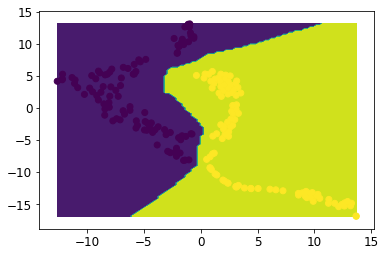

In [9]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

np.random.seed(42)

X, Y = make_moons(1000, noise=0.1)
#####################################################################
# Perform a train test split , use 20% of the dataset for testing.
#####################################################################
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

#####################################################################
# Perform a polynomial feature transform  use degree 10
#####################################################################
from sklearn.preprocessing import *
poly = PolynomialFeatures(10)
x_train_poly = poly.fit_transform(x_train)
model = SGDClassifier(tol = None, loss="log", alpha = 0.002, penalty = "l2")
model.fit(x_train_poly, y_train)
x_test_poly = poly.fit_transform(x_test)

#####################################################################
# Plot the decision boundary 
#####################################################################
plot_decision_boundary(model, x_test_poly, y_test)

## MNIST

Extract from the dataset digits 0 and 8.

In [8]:
###########################################################################
# Extract ones and eights digits from both training and testing data 
############################################################################
labels_to_select = [0,8]
selected_train_data, selected_train_labels = sample_data_digits(train_x_mnist, train_y_mnist, labels_to_select)
selected_test_data, selected_test_labels = sample_data_digits(test_x_mnist, test_y_mnist, labels_to_select)

In [22]:
from sklearn.base import BaseEstimator, ClassifierMixin
class LogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.05, num_iter=1000, add_bias=True, verbose=True,lambda_val=0.5,penalty='L1'):
        self.lr = lr
        self.lambda_val = lambda_val
        self.verbose = verbose
        self.num_iter = num_iter
        self.add_bias = add_bias
        self.penalty = penalty
        
    
    def __add_bias(self, X):
        bias = np.ones((X.shape[0], 1))
        return np.concatenate((bias, X), axis=1)
    

    ############################################################################
    #  compute the loss + ADD PENALTY HERE
    ############################################################################
    def __loss(self, h, y):
        ''' computes loss values '''
        y = np.array(y,dtype=float)
        
        # ADD YOUR CODE HERE
        if self.penalty == 'L2':
            reg = 0.5*self.lambda_val * np.matmul(self.theta, np.transpose(self.theta)) #L2 norm
        elif self.penalty == 'L1':
            reg = self.lambda_val * np.linalg.norm(self.theta,1) #L1 norm
        else:
            reg = 0
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)+ reg ).mean()

    
    def fit(self, X, y):
        ''' 
        Optimise the model using gradient descent
        Arguments:
            X input features
            y labels from training data
            
        '''
        if self.add_bias:
            X = self.__add_bias(X)
        
        
        ############################################################################
        #initialise weights randomly with normal distribution N(0,1)
        ############################################################################
        self.theta = np.random.normal(0.0,0.01,X.shape[1])
        
        for i in range(self.num_iter):
            ############################################################################
            #  forward propagation
            ############################################################################
            z = X.dot(self.theta)
            h = 1.0 / (1.0 + np.exp(-z))
            ############################################################################
            #  backward propagation + ADD PENALTY HERE
            ############################################################################
            # update parameters
            
            reg = np.array([0 for k in range(len(self.theta))])
            if self.penalty == 'L2':
                reg = self.lambda_val * self.theta #L2 norm
            elif self.penalty == 'L1':
                #L1 norm
                reg = np.array([1 for k in range(len(self.theta))])
                for k in range(len(self.theta)):
                    if self.theta[k]<0:
                        reg[k]=-1
            else:
                reg = np.array([0 for k in range(len(self.theta))])
            self.theta -= self.lr * ( np.dot(X.T, (h - y))+reg) / y.size
            


            ############################################################################
            # print loss
            ############################################################################
            if(self.verbose == True and i % 50 == 0):
                h = 1.0 / (1.0 + np.exp(-X.dot(self.theta)))
                print('loss: {} \t'.format(self.__loss(h, y)))
    
    def predict_probs(self,X):
        ''' returns output probabilities
        '''
        ############################################################################
        # forward propagation
        ############################################################################
        if self.add_bias:
            X = self.__add_bias(X)
        z = X.dot(self.theta)
        return 1.0 / (1.0 + np.exp(-z))

    def predict(self, X, threshold=0.5):
        ''' returns output classes
        '''
        return self.predict_probs(X) >= threshold
    
    def score(self, X,Y):
        '''
            Returns accuracy of model
        '''
        preds = self.predict(X)
        accuracy = (preds == Y).mean()
        return accuracy
    

### Deploying Regressor with regularisation

loss: 0.6774344414956851 	
loss: 0.5490156697838957 	
loss: 0.4676366686955057 	
loss: 0.40801834478931287 	
loss: 0.3618210462720561 	
loss: 0.3250134598769958 	
loss: 0.2951125457853307 	
loss: 0.27042598711205307 	
loss: 0.24975114527583353 	
loss: 0.23221340252385014 	
loss: 0.21716542702106853 	
loss: 0.20412055078102018 	
loss: 0.1927075099757217 	
loss: 0.18263916821532528 	
loss: 0.17369058728002632 	
loss: 0.1656834379866788 	
loss: 0.15847476797346005 	
loss: 0.15194880227735208 	
loss: 0.14601088214726254 	
loss: 0.14058293047418727 	
loss: 0.13560002057655812 	
loss: 0.13100775187486394 	
loss: 0.12676022232810516 	
loss: 0.12281844697715504 	
loss: 0.11914911337759908 	
loss: 0.11572359390085916 	
loss: 0.11251715567779684 	
loss: 0.10950832392620259 	
loss: 0.10667836528443236 	
loss: 0.10401086575970814 	
loss: 0.1014913838151198 	
loss: 0.09910716353940041 	
loss: 0.09684689617370819 	
loss: 0.09470052079858277 	
loss: 0.09265905691924896 	
loss: 0.09071446317866479 	
l

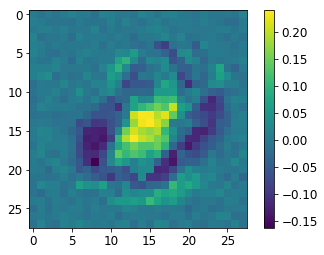

loss: 5.080716230224631 	
loss: 4.791182129130651 	
loss: 4.761507639276455 	
loss: 4.806243973788222 	
loss: 4.871617977653888 	
loss: 4.947850401770452 	
loss: 5.0221731994837935 	
loss: 5.088465938242424 	
loss: 5.147081372586169 	
loss: 5.1973780749223595 	
loss: 5.237290935453553 	
loss: 5.273720044173976 	
loss: 5.305822654090774 	
loss: 5.336258342594203 	
loss: 5.365703747895304 	
loss: 5.3946068442078605 	
loss: 5.424191263923809 	
loss: 5.453159759943464 	
loss: 5.480105647316962 	
loss: 5.506782081460619 	
loss: 5.535081450445661 	
loss: 5.563737622725706 	
loss: 5.592587235136932 	
loss: 5.622554818562444 	
loss: 5.652680100331104 	
loss: 5.6823591757688225 	
loss: 5.712023036084363 	
loss: 5.741350269568105 	
loss: 5.769989907985191 	
loss: 5.7980724210111925 	
loss: 5.826995052713045 	
loss: 5.854802483417972 	
loss: 5.881295019377615 	
loss: 5.907756358826258 	
loss: 5.933245912289114 	
loss: 5.95858677278119 	
loss: 5.983782955825867 	
loss: 6.0080052922662635 	
loss: 6

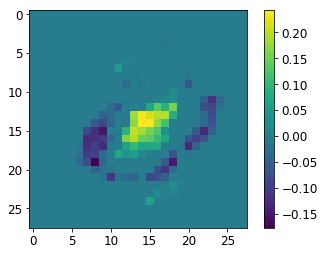

loss: 0.7316057594502434 	
loss: 0.600670476225875 	
loss: 0.519774238018579 	
loss: 0.4631442675563557 	
loss: 0.42174184046691404 	
loss: 0.39095526449645646 	
loss: 0.36787272068313487 	
loss: 0.3505007331566056 	
loss: 0.337429916844921 	
loss: 0.3276450342782317 	
loss: 0.3204034509121054 	
loss: 0.31515407433530873 	
loss: 0.31148229841301506 	
loss: 0.30907211588040584 	
loss: 0.3076797148088723 	
loss: 0.30711484005745615 	
loss: 0.30722746468153966 	
loss: 0.30789813615309325 	
loss: 0.3090308972787691 	
loss: 0.3105480334045545 	
loss: 0.3123861307875554 	
loss: 0.31449308736701526 	
loss: 0.3168258231154567 	
loss: 0.3193485097629949 	
loss: 0.32203119001969577 	
loss: 0.3248486916995051 	
loss: 0.32777976714589535 	
loss: 0.3308064062565328 	
loss: 0.33391328434730944 	
loss: 0.3370873155464672 	
loss: 0.3403172893731134 	
loss: 0.34359357333046536 	
loss: 0.3469078682235771 	
loss: 0.3502530058419318 	
loss: 0.3536227808778933 	
loss: 0.35701181066197135 	
loss: 0.36041541

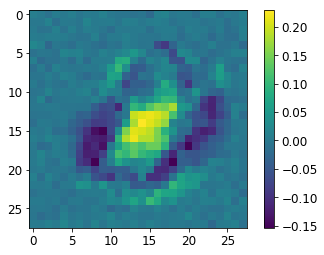

In [23]:
#########################################################################
# train the model using raw pixels , train for all penalties and for various lambda values
#########################################################################
for pen in ['None','L1','L2']:
    for lam_val in [0.7]:
      
        #########################################################################
        # Evaluate the trained model - compute train and test accuracies
        #########################################################################
        
        model = LogisticRegression(lr=1e-3, num_iter=10000, add_bias=True, verbose=True,lambda_val=lam_val,penalty=pen)
        model.fit(selected_train_data[:75],selected_train_labels[:75])
        selected_train_results = model.predict(selected_train_data)
        selected_test_results = model.predict(selected_test_data)
        count1 = 0
        count2 = 0
        for i in range(75):
            if selected_train_results[i] and selected_train_labels[i] == 1:
                count1 += 1
            if selected_train_results[i]==False and selected_train_labels[i] == 0:
                count1 += 1
        for i in range(len(selected_test_results)):
            if selected_test_results[i] and selected_test_labels[i] == 1:
                count2 += 1
            if selected_test_results[i]==False and selected_test_labels[i] == 0:
                count2 += 1
        print("penalty =", pen)
        print("training accuracy is", count1/75)
        print("testing accuracy is", count2/selected_test_labels.size)
        
        #########################################################################
        # draw trained model params (weights) as an image of size (28x28)
        #########################################################################
        plt.imshow(model.theta[:-1].reshape(28,28))
        plt.colorbar()
        plt.show()

### Regularisation using sklearn

In [11]:
############################################################################
############################################################################
# reshape to (N,728) this is number of samples N and the nuber of features 28x28=728
x_train=np.reshape(train_x_mnist,(train_x_mnist.shape[0],train_x_mnist.shape[1]*train_x_mnist.shape[2]))
x_test=np.reshape(test_x_mnist,(test_x_mnist.shape[0],test_x_mnist.shape[1]*test_x_mnist.shape[2]))

In [13]:
############################################################################
############################################################################
# No Regularisation 
############################################################################

mymodel1 = SGDClassifier(max_iter = 20, tol = 1e-3, alpha = 0.1, loss="log", penalty = "none")
mymodel1.fit(x_train, train_y_mnist)
print("accuracy of train set", mymodel1.score(x_train, train_y_mnist))
print("accuracy of test set", mymodel1.score(x_test, test_y_mnist))

############################################################################
# L1 Reguralization 
############################################################################

mymodel2 = SGDClassifier(max_iter = 20, tol = 1e-3, alpha = 0.1, loss="log", penalty = "l1")
mymodel2.fit(x_train, train_y_mnist)
print("accuracy of train set", mymodel2.score(x_train, train_y_mnist))
print("accuracy of test set", mymodel2.score(x_test, test_y_mnist))

############################################################################
# L2 Reguralization 
############################################################################

mymodel3 = SGDClassifier(max_iter = 20, tol = 1e-3, alpha = 0.1, loss="log", penalty = "l2")
mymodel3.fit(x_train, train_y_mnist)
print("accuracy of train set", mymodel3.score(x_train, train_y_mnist))
print("accuracy of test set", mymodel3.score(x_test, test_y_mnist))

accuracy of train set 0.8383666666666667
accuracy of test set 0.8471
accuracy of train set 0.8140166666666667
accuracy of test set 0.8223
accuracy of train set 0.88995
accuracy of test set 0.8838


## Validation 

In [14]:
from sklearn.model_selection import train_test_split
############################################################################
# Split into train and val test_size=0.10, random_state=42
############################################################################
x_train, x_val, y_train, y_val = train_test_split(train_x_mnist, train_y_mnist, test_size = 0.1, random_state = 42)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
x_val=np.reshape(x_val,(x_val.shape[0],x_val.shape[1]*x_val.shape[2]))
#Initialize best values
best = [0,0,0]

############################################################################
# Iterate over selected values
############################################################################
for lr in [1e-2,1e-3,1e-6]:
    for al in [0.5,0.1,0.01]:
        
        mymodel4 = SGDClassifier(max_iter = 20, learning_rate = 'constant', eta0 = lr, alpha = al, tol = 1e-3, loss="log", penalty = "l2")
        mymodel4.fit(x_train, y_train)
        t = mymodel4.score(x_val, y_val)
        if t > best[2]:
            best=[lr, al, t]
        
 # print best hyperparameters and accuracy   
print(best)

[1e-06, 0.01, 0.8896666666666667]
